# Optimizing Forest Fire Model Predictions Using Linear Regression

In this project, we will predict the impact of forest fires in the northeast region of Portugal using linear regression. The dataset we'll be working with, [Forest Fires](https://archive.ics.uci.edu/dataset/162/forest+fires), is sourced from the UCI Machine Learning Repository, with a slightly modified version tailored for our specific needs.

We’ll begin by creating a baseline model that uses the features "temp" (temperature) and "wind" (wind speed) to predict "area" (the burned area) as our target variable. From there, we'll explore several variations of linear regression models, iterating to optimize predictive performance and improve upon our reference model.

Let’s get started!

In [11]:
# Importing Libraries
import pandas as pd
import numpy as np

# Importing matplotlib and seaborn for visuals
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Importing LinearRegression from scikit-learn
from sklearn.linear_model import LinearRegression

In [4]:
# Loading Forest Fires dataset
ff = pd.read_csv('fires.csv')

In [5]:
# Showing first 5 rows
ff.head()

,Unnamed: 0,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,1,7,5,mar,fri,86.2,26.2,94.3,5.1,NaN,51.0,6.7,0.0,0.0
1,2,7,4,oct,tue,90.6,NaN,669.1,6.7,18.0,33.0,0.9,0.0,0.0
2,3,7,4,oct,sat,90.6,43.7,NaN,6.7,14.6,33.0,1.3,0.0,0.0
3,4,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97.0,4.0,0.2,0.0
4,5,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99.0,NaN,0.0,0.0


Below are descriptions of each column from the Forest Fires dataset straight from the UCI Machine Learning Repository.

* `X` - x-axis spatial coordinate within the Montesinho park map: 1 to 9
* `Y` - y-axis spatial coordinate within the Montesinho park map: 2 to 9
* `month` - month of the year: 'jan' to 'dec' 
* `day` - day of the week: 'mon' to 'sun'
* `FFMC` - FFMC index from the FWI system: 18.7 to 96.20
* `DMC` - DMC index from the FWI system: 1.1 to 291.3 
* `DC` - DC index from the FWI system: 7.9 to 860.6 
* `ISI` - ISI index from the FWI system: 0.0 to 56.10
* `temp` - temperature in Celsius degrees: 2.2 to 33.30
* `RH` - relative humidity in %: 15.0 to 100
* `wind` - wind speed in km/h: 0.40 to 9.40 
* `rain` - outside rain in mm/m2 : 0.0 to 6.4 
* `area` - the burned area of the forest (in ha): 0.00 to 1090.84 
  (this output variable is very skewed towards 0.0, thus it may make
  sense to model with the logarithm transform).

In [4]:
ff.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  517 non-null    int64  
 1   X           517 non-null    int64  
 2   Y           517 non-null    int64  
 3   month       517 non-null    object 
 4   day         517 non-null    object 
 5   FFMC        469 non-null    float64
 6   DMC         496 non-null    float64
 7   DC          474 non-null    float64
 8   ISI         515 non-null    float64
 9   temp        496 non-null    float64
 10  RH          487 non-null    float64
 11  wind        482 non-null    float64
 12  rain        485 non-null    float64
 13  area        517 non-null    float64
dtypes: float64(9), int64(3), object(2)
memory usage: 56.7+ KB


In [5]:
# Amount of missing values in FFMC
sum(ff['FFMC'].isnull())

48

There are `517` rows with `14` columns. Of those columns, `8` of them have missing data. `DC` has the most missing values with `48`. "month" and "day" are categorical while the rest are numerical. 

# Data Processing

Next, we’ll move on to data processing. This involves transforming the raw data into a format suitable for analysis, including tasks like encoding categorical variables, scaling features, and handling missing values. This step ensures our data is ready for modeling.

Text(0.5, 1.0, "Distribution of 'Area'")

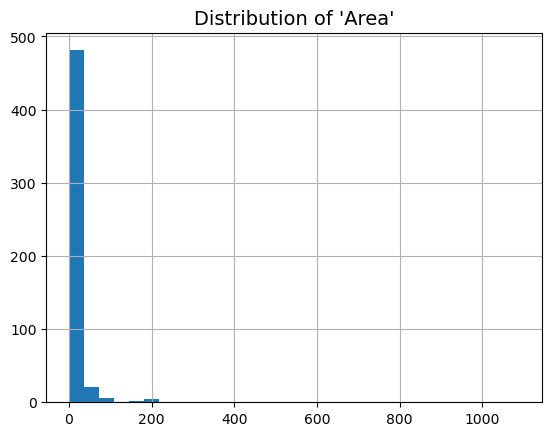

In [9]:
# Distrubution of 'area' using histogram
ff['area'].hist(bins=30)

# Title
plt.title("Distribution of 'Area'", size=14)

In [7]:
# Looking at unique values and their frequencies
ff['area'].value_counts().sort_index()

0.00       247
0.09         1
0.17         1
0.21         1
0.24         1
          ... 
200.94       1
212.88       1
278.53       1
746.28       1
1090.84      1
Name: area, Length: 251, dtype: int64

The distrubution of our output variable is skewed to the right. Most of its values are zero or close to it. It might be a good idea to log-transform this output variable. Since log(0) is undefined, we'll add 1 to prevent any errors.

Text(0.5, 1.0, "Distribution of 'log_Area'")

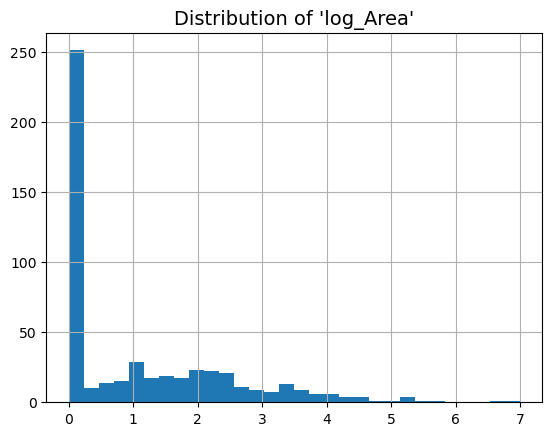

In [10]:
# Log transforming 'area'
ff['log_area'] = np.log(ff['area'] + 1)

# Distribution of log_area using histogram
ff['log_area'].hist(bins=30)

# Title
plt.title("Distribution of 'log_Area'", size=14)

The disribution is still skewed to the right having most of its values at around `0`. But most of the values are more spread out than the non-log area, which is better. 

Let's take a look at the month column.

In [9]:
# Month distribution
ff['month'].value_counts()

aug    184
sep    172
mar     54
jul     32
feb     20
jun     17
oct     15
apr      9
dec      9
jan      2
may      2
nov      1
Name: month, dtype: int64

Except for an anomaly in the month of March, most fires occur during the summer months, which are typically the hottest and driest of the year. It makes sense, then, that fire frequency peaks during this period. To capture this seasonal pattern, we'll transform the "month" column into a binary indicator that flags whether a fire occurred in the summer (June, July, August, or September). We'll create a new column, "summer," where a value of `1` will indicate a fire took place in one of these months.

In [13]:
# Function to iterate over 'month' to return indicators
def is_summer(month):
    if month in ['jun', 'jul', 'aug', 'sep']:
        return 1
    else:
        return 0

# Applying function to create 'summer' column
ff['summer'] = [is_summer(m) for m in ff["month"]]

# Checking summer counts
ff['summer'].value_counts()

1    405
0    112
Name: summer, dtype: int64

The next step is to handle the missing values in the dataset. We'll use K-Nearest Neighbors (KNN) imputation to fill in the gaps, as we expect that the damage from a fire ("area") is likely to be similar for fires with comparable characteristics.

In [14]:
# Loading K-Nearest Neighbors imputer library
from sklearn.impute import KNNImputer

# Instatiating KNN imputer
imp = KNNImputer(missing_values=np.nan, n_neighbors=3)

# Indexing columns to be imputed, 'FFMC' to 'rain'
missing_ff = ff[ff.columns[5:13]]

# Converting imputed array back to dataframe
imputed_ff = pd.DataFrame(imp.fit_transform(missing_ff), columns=missing_ff.columns)

In [12]:
# Checking for missing values
imputed_ff.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   FFMC    517 non-null    float64
 1   DMC     517 non-null    float64
 2   DC      517 non-null    float64
 3   ISI     517 non-null    float64
 4   temp    517 non-null    float64
 5   RH      517 non-null    float64
 6   wind    517 non-null    float64
 7   rain    517 non-null    float64
dtypes: float64(8)
memory usage: 32.4 KB


In [32]:
# First 5 rows of imputed_ff
imputed_ff.head()

,FFMC,DMC,DC,ISI,temp,RH,wind,rain
0,86.2,26.200000,94.300000,5.1,16.6,51.0,6.700000,0.0
1,90.6,56.433333,669.100000,6.7,18.0,33.0,0.900000,0.0
2,90.6,43.700000,470.833333,6.7,14.6,33.0,1.300000,0.0
3,91.7,33.300000,77.500000,9.0,8.3,97.0,4.000000,0.2
4,89.3,51.300000,102.200000,9.6,11.4,99.0,4.333333,0.0


Next, we'll check for any outliers in each column using boxplots. Outliers will be identified as points that fall outside the quartile ranges, appearing as dots above or below the "whiskers" of the boxplot.

Text(0.5, 1.0, "Boxplot of 'imputed_ff'")

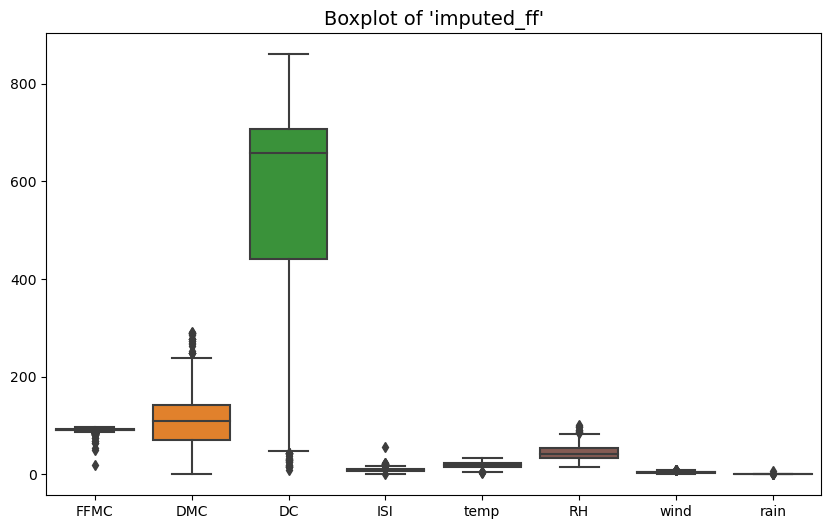

In [21]:
# Figure size
plt.figure(figsize=(10,6))

# Boxplot for imputed_ff 
sns.boxplot(imputed_ff)

# Title
plt.title("Boxplot of 'imputed_ff'", size=14)

In [34]:
# Descriptive statistics
imputed_ff.describe()

,FFMC,DMC,DC,ISI,temp,RH,wind,rain
count,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000
mean,90.658930,110.886912,544.791231,9.016054,18.896970,44.355255,4.018569,0.021663
std,5.494697,63.452541,244.178695,4.556973,5.774151,15.884310,1.772620,0.295959
min,18.700000,1.100000,7.900000,0.000000,2.200000,15.000000,0.400000,0.000000
25%,90.300000,70.800000,442.100000,6.500000,15.600000,33.000000,2.700000,0.000000
50%,91.600000,108.300000,658.200000,8.400000,19.300000,42.000000,4.000000,0.000000
75%,92.800000,141.300000,706.700000,10.700000,22.800000,53.000000,4.900000,0.000000
max,96.200000,291.300000,860.600000,56.100000,33.300000,100.000000,9.400000,6.400000


Based on the boxplot and the descriptive statistics from the `describe()` function, we can see potential outliers. To confirm this, we'll calculate the interquartile range (IQR) for each column and identify any values that fall outside the lower and upper bounds.

In [42]:
# Represents each quartile
percentile = [25, 50, 75]

# Loop through each column in imputed_ff
for col in imputed_ff:
    
    # Calculates each quartile for each column
    col_quartiles = np.percentile(imputed_ff[col], percentile)
    
    # Inner quartile range
    iqr = col_quartiles[2] - col_quartiles[0]
    
    # Lower line below the box on the boxplot graph, below this line are outliers
    lower_bound = col_quartiles[0] - (1.5 * iqr)
    
    # Upper line above the box on the boxplot graph, above this line are outliers
    upper_bound = col_quartiles[2] + (1.5 * iqr)
    
    # Masks that counts and determines ouliers for each column above or below the bound lines, respectively
    n_of_outliers = imputed_ff[(imputed_ff[col] < lower_bound) | (imputed_ff[col] > upper_bound)].shape[0]
    
    col_outliers_mask = imputed_ff[(imputed_ff[col] < lower_bound) | (imputed_ff[col] > upper_bound)]
    
    print('---------------------')
    print(f'\n{col} has {n_of_outliers} outliers\n')
    print(col_outliers_mask[col])

---------------------

FFMC has 53 outliers

0      86.200000
12     63.500000
17     84.900000
19     86.300000
40     79.500000
58     84.000000
75     84.200000
96     83.900000
97     69.000000
104    82.100000
105    85.900000
110    85.900000
123    84.400000
130    68.200000
138    85.800000
147    84.400000
165    84.900000
171    85.600000
176    84.433333
196    81.500000
199    63.500000
202    83.900000
233    84.400000
239    81.900000
241    83.000000
273    84.533333
274    84.000000
275    84.600000
276    85.400000
277    85.400000
278    85.400000
279    85.400000
280    84.700000
281    85.400000
282    84.900000
284    85.200000
299    53.400000
312    50.400000
379    18.700000
390    84.700000
394    84.100000
395    85.000000
407    83.833333
410    84.100000
411    84.600000
463    75.100000
464    75.100000
465    79.500000
511    81.600000
512    81.600000
513    81.600000
514    81.600000
516    79.500000
Name: FFMC, dtype: float64
---------------------

DMC 

Above, we show the number of outliers in each column (as determined by the IQR method) along with the actual outlier values. After carefully examining each outlier and conducting further research, it appears that these outliers are naturally occurring values. Therefore, we have decided to retain them in the dataset, as removing them could risk introducing bias into the model by ignoring these valid data points.

Next we will standardize our data to have each column on the same value scale. This will give our model a better chance at making better predictions.

In [45]:
# Importing our scaler
from sklearn.preprocessing import StandardScaler

# Instantiating the scaler
scaler = StandardScaler()

# Applying the scaler to our data
scaled_ff = scaler.fit_transform(imputed_ff)

# Converting back to a dataframe
scaled_ff = pd.DataFrame(scaled_ff, columns=imputed_ff.columns)

# First 5 rows
scaled_ff.head()

,FFMC,DMC,DC,ISI,temp,RH,wind,rain
0,-0.812283,-1.335942,-1.846711,-0.860187,-0.398187,0.418726,1.514159,-0.073268
1,-0.010735,-0.859009,0.509582,-0.508736,-0.155493,-0.715565,-1.761003,-0.073268
2,-0.010735,-1.059878,-0.303178,-0.508736,-0.744894,-0.715565,-1.535130,-0.073268
3,0.189652,-1.223939,-1.915580,-0.003526,-1.837021,3.317471,-0.010485,0.603155
4,-0.247556,-0.939988,-1.814327,0.128267,-1.299625,3.443503,0.177742,-0.073268


Now let's add the column 'summer' back into our dataset.

In [47]:
# Combining 'summer' and our scaled data
final = pd.concat([ff['summer'], scaled_ff], axis=1)

final

,summer,FFMC,DMC,DC,ISI,temp,RH,wind,rain
0,0,-0.812283,-1.335942,-1.846711,-0.860187,-0.398187,0.418726,1.514159,-0.073268
1,0,-0.010735,-0.859009,0.509582,-0.508736,-0.155493,-0.715565,-1.761003,-0.073268
2,0,-0.010735,-1.059878,-0.303178,-0.508736,-0.744894,-0.715565,-1.535130,-0.073268
3,0,0.189652,-1.223939,-1.915580,-0.003526,-1.837021,3.317471,-0.010485,0.603155
4,0,-0.247556,-0.939988,-1.814327,0.128267,-1.299625,3.443503,0.177742,-0.073268
...,...,...,...,...,...,...,...,...,...
512,1,-1.650265,-0.854803,0.495235,-1.563087,1.543370,-0.778581,-0.744573,-0.073268
513,1,-1.650265,-0.854803,0.495235,-1.563087,0.520585,1.679050,1.005944,-0.073268
514,1,-1.650265,-0.854803,0.495235,-1.563087,0.399238,1.616034,1.514159,-0.073268
515,1,0.681511,0.553912,0.286579,0.501683,1.161993,-0.148419,-0.010485,-0.073268


# Visualizing Relationships with "log_Area"

We want to visualize the relationships between each feature (column) and our target variable, log_area. Looking at these realtionships can give us ideas of how the features are related to our target variable allowing us to choose the best models for our data.

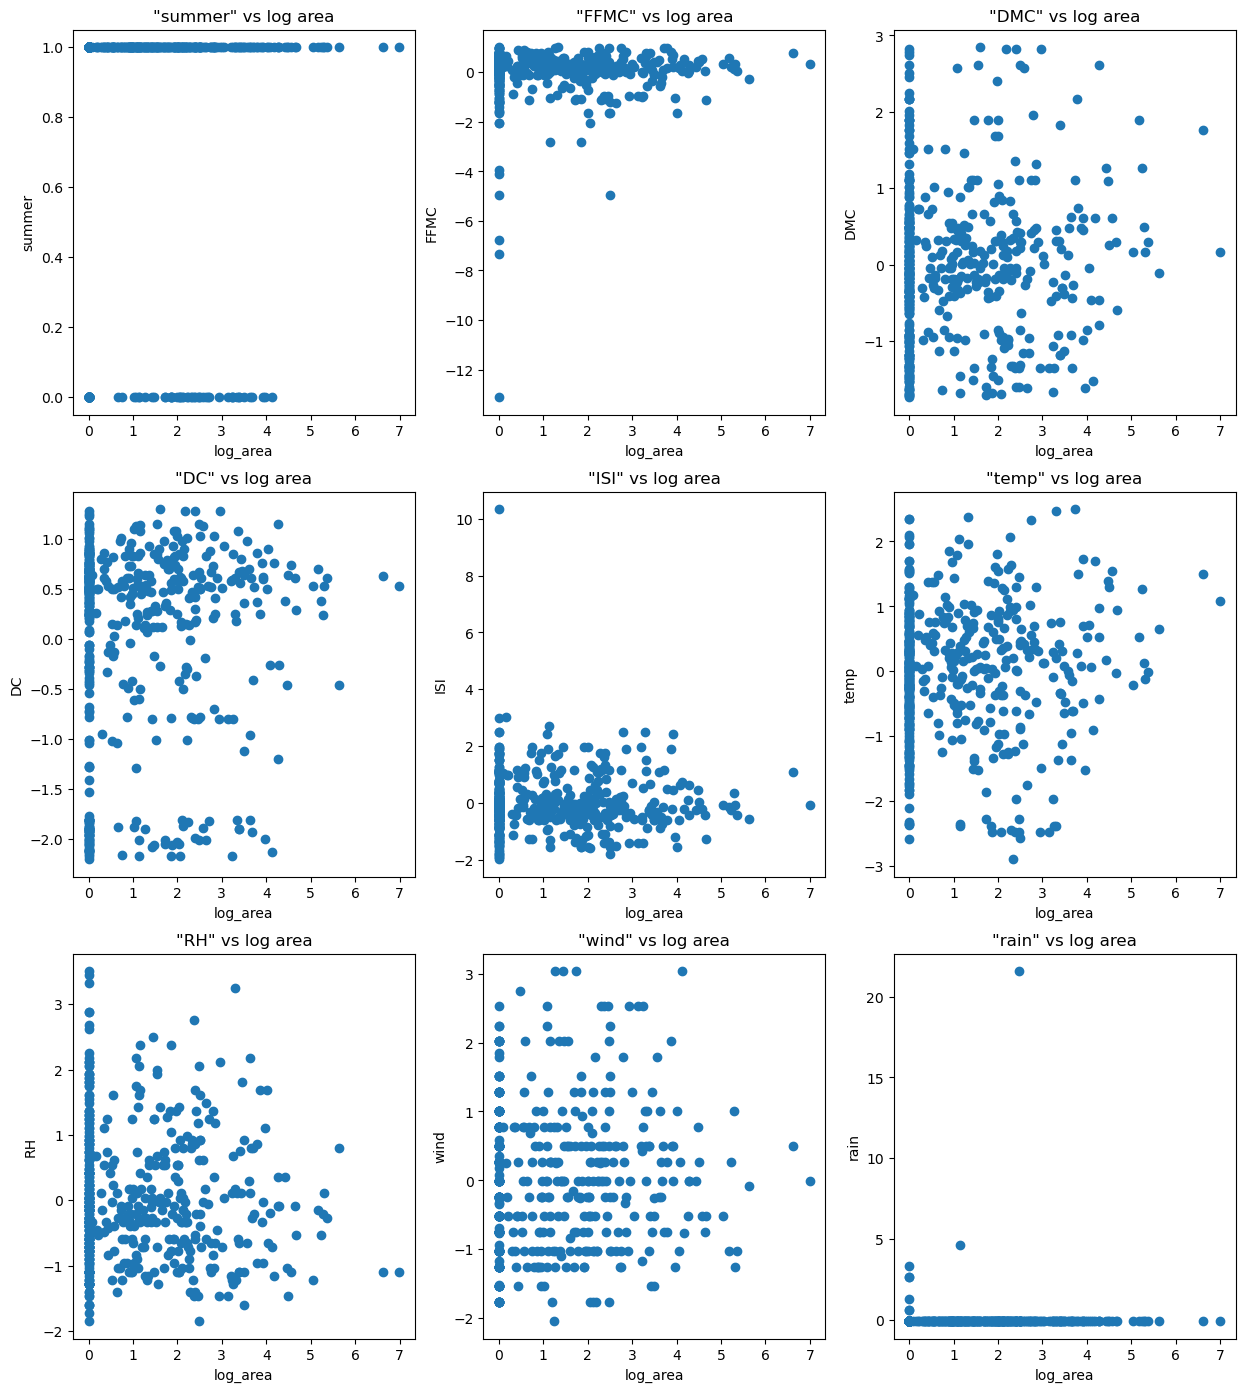

In [88]:
# Figure size
plt.figure(figsize=(15, 17))

# Scatterplot each column against 'log_area'
for i, col in enumerate(final):
    
    # Subplots for each column
    plt.subplot(3, 3, i+1)
   
    # Scatterplots
    plt.scatter(ff['log_area'], final[col])
    
    # Formatted axis labels and title
    plt.xlabel('log_area')
    plt.ylabel(col)
    plt.title(f'"{col}" vs log area', size=12)

None of these plots are showing signs of polynomial trends. Therfore we can count out using polynomial regression models. Only a few of the features stick out to me having some sort of a trend with log area. Those features are summer, FFMC, ISI, and rain. 

* summer - Non summer months, log area max's around 4, but summer months range up to 7.
* FFMC - Most of the observations hang around the 90-ish mark as log area ranges mainly from 0 to 5. 
* ISI -  A bulk of the observations hang around the 10 mark as log area ranges mainly from 0 to 6.
* rain - Most of the observations have a value of zero with log area ranging from 0 to 7.

The range of log area is all over the place for each each feature. It will be interesting to see what our models prediction's can come up with using these features.

# Subset Selection

We're going to select groups of features for a model using a  process called sequential feature selection, or subset selection. We'll load in the library `SequentialFeatureSelector` from scikit-learn which uses an algorithm that iterates over each feature in the dataset to see which one would produce the best model based on mean squared error. There's a forward method and a backward method. Forward iterates thru the features from the front of the list and backwards is vice versa. Let's impliment both methods here with a variety of different number of features to choose from.

In [85]:
# Import SequentialFeatureSelector library
from sklearn.feature_selection import SequentialFeatureSelector

# Target variable
y = ff['log_area']

# Model to use
lm = LinearRegression()

In [86]:
# Instantiating forward models with different number of features (2, 4, and 6)
forward2 = SequentialFeatureSelector(estimator=lm,
                                    n_features_to_select=2, 
                                    direction="forward")

forward4 = SequentialFeatureSelector(estimator=lm,
                                    n_features_to_select=4, 
                                    direction="forward")

forward6 = SequentialFeatureSelector(estimator=lm,
                                   n_features_to_select=6,
                                   direction='forward')


# Fitting data
forward2.fit(final, y)
forward4.fit(final, y)
forward6.fit(final, y)

# Printing out the features each model chose
print(f'Features selected in forward2 model: {forward2.get_feature_names_out()}')
print(f'Features selected in forward4 model: {forward4.get_feature_names_out()}')
print(f'Features selected in forward6 model: {forward6.get_feature_names_out()}')

Features selected in forward2 model: ['FFMC' 'DC']
Features selected in forward4 model: ['FFMC' 'DC' 'RH' 'wind']
Features selected in forward6 model: ['summer' 'FFMC' 'DC' 'ISI' 'RH' 'wind']


In [87]:
# Instantiating backward models with different number of features (2, 4, and 6)
backward2 = SequentialFeatureSelector(estimator=lm,
                                    n_features_to_select=2, 
                                    direction="backward")

backward4 = SequentialFeatureSelector(estimator=lm,
                                    n_features_to_select=4, 
                                    direction="backward")

backward6 = SequentialFeatureSelector(estimator=lm,
                                   n_features_to_select=6,
                                   direction='backward')


# Fitting data
backward2.fit(final, y)
backward4.fit(final, y)
backward6.fit(final, y)

# Printing out the features each model chose
print(f'Features selected in backward2 model: {backward2.get_feature_names_out()}')
print(f'Features selected in backward4 model: {backward4.get_feature_names_out()}')
print(f'Features selected in backward6 model: {backward6.get_feature_names_out()}')

Features selected in backward2 model: ['DC' 'wind']
Features selected in backward4 model: ['FFMC' 'DC' 'RH' 'wind']
Features selected in backward6 model: ['summer' 'FFMC' 'DC' 'ISI' 'RH' 'wind']


The common features selected from our forward and backward models are `FFMC`, `DC`, and `wind`.

# Ridge and LASSO Models

Ridge and LASSO regression models are two different types of regularization techniques that reduces the complexity of a model by penalizing high coefficients, helping for feature selection. The higher the coefficients for the ridge model, the more important that feature is. The non-zero coefficients for the lasso model, the more important those features are.

In [112]:
# Importing RidgeCV library
from sklearn.linear_model import RidgeCV

# Instantiating RidgeCV with tuning parameter range
ridge = RidgeCV(alphas=np.linspace(2300, 2400, num=100))

# Fitting data
ridge.fit(final, y)

print(f'RidgeCV Feature Order: {ridge.feature_names_in_}')
print(f'RidgeCV Coefficients: {ridge.coef_}\n')
print(f'RidgeCV Tuning Parameter: {ridge.alpha_}')

RidgeCV Feature Order: ['summer' 'FFMC' 'DMC' 'DC' 'ISI' 'temp' 'RH' 'wind' 'rain']
RidgeCV Coefficients: [ 0.00231138  0.00926731  0.01340864  0.0137932  -0.00602348  0.00908162
 -0.0101807   0.01700565  0.00546081]

RidgeCV Tuning Parameter: 2346.4646464646466


The stronger features according to ridge regression are DMC, DC, and wind.

In [109]:
# Importing LassoCV library
from sklearn.linear_model import LassoCV

# Instantiating LassoCV with tuning parameter range
lasso = LassoCV(alphas=np.linspace(1, 1000, num=100))

# Fitting data
lasso.fit(final, y)

print(f'LassoCV Feature Order: {lasso.feature_names_in_}')
print(f'LassoCV Coefficients: {lasso.coef_}\n')
print(f'LassoCV Tuning Parameter: {lasso.alpha_}')

LassoCV Feature Order: ['summer' 'FFMC' 'DMC' 'DC' 'ISI' 'temp' 'RH' 'wind' 'rain']
LassoCV Coefficients: [ 0.  0.  0.  0. -0.  0. -0.  0.  0.]

LassoCV Tuning Parameter: 1000.0


According to the LASSO regression model, none of the features are worth using! The tuning parameter was always on the extreme side no matter the size of the range. 

We'll go ahead and only use our ridge model with the rest of our K-fold cross validation tests.

# K-Fold Cross-Validation

Let's instantiate linear regression models for all the different types of models we will be running and use K-Fold cross validation on each. K-Fold cross validation divides a dataset into subsets (folds), allowing a model to be trained and tested iteratively, giving us more reliable evaluation scores. 

In [114]:
## Instantiating linear regression for all models

# Reference model
reference = LinearRegression()

# Forward models
fw2 = LinearRegression()
fw4 = LinearRegression()
fw6 = LinearRegression()

# Backward models
bw2 = LinearRegression()
bw4 = LinearRegression()
bw6 = LinearRegression()

In [127]:
# Importing cross validation library
from sklearn.model_selection import cross_val_score

# Reference CV model
reference_cv = cross_val_score(reference, final[['wind', 'temp']], y, cv=5, scoring='neg_mean_squared_error')

# Forward CV models
fw2_cv = cross_val_score(fw2, final[forward2.get_feature_names_out()], y, cv=5, scoring='neg_mean_squared_error')
fw4_cv = cross_val_score(fw4, final[forward4.get_feature_names_out()], y, cv=5, scoring='neg_mean_squared_error')
fw6_cv = cross_val_score(fw6, final[forward6.get_feature_names_out()], y, cv=5, scoring='neg_mean_squared_error')

# Backward CV models
bw2_cv = cross_val_score(bw2, final[backward2.get_feature_names_out()], y, cv=5, scoring='neg_mean_squared_error')
bw4_cv = cross_val_score(bw4, final[backward4.get_feature_names_out()], y, cv=5, scoring='neg_mean_squared_error')
bw6_cv = cross_val_score(bw6, final[backward6.get_feature_names_out()], y, cv=5, scoring='neg_mean_squared_error')

# Ridge CV model
ridge_cv = cross_val_score(ridge, final, y, cv=5, scoring='neg_mean_squared_error')


print(f'reference model Average Negative MSE Score: {np.mean(reference_cv)}')
print(f'forward2 model Average Negative MSE Score: {np.mean(fw2_cv)}')
print(f'forward4 model Average Negative MSE Score: {np.mean(fw4_cv)}')
print(f'forward6 model Average Negative MSE Score: {np.mean(fw6_cv)}')
print(f'backward2 model Average Negative MSE Score: {np.mean(bw2_cv)}')
print(f'backward4 model Average Negative MSE Score: {np.mean(bw4_cv)}')
print(f'backward6 model Average Negative MSE Score: {np.mean(bw6_cv)}')
print(f'ridge model Average Negative MSE Score: {np.mean(ridge_cv)}')

reference model Average Negative MSE Score: -2.204650013004116
forward2 model Average Negative MSE Score: -2.173543172119853
forward4 model Average Negative MSE Score: -2.1935281067727113
forward6 model Average Negative MSE Score: -2.217382522951446
backward2 model Average Negative MSE Score: -2.173357302739327
backward4 model Average Negative MSE Score: -2.1935281067727113
backward6 model Average Negative MSE Score: -2.217382522951446
ridge model Average Negative MSE Score: -2.182741879902077


With negative mean squared error (negative mse), the closer to zero the better. Zero means our model predicted perfectly. Our best model is our backward2 model with an average negative mse score of -2.1733. Given that our target variable is on the log scale, our score is not too good.

# Examining Model Weaknesses

Let's examine our best model, backward2, using a residuals plot. A residuals plot shows the variance of error in our model. 

Text(0, 0.5, 'Residuals')

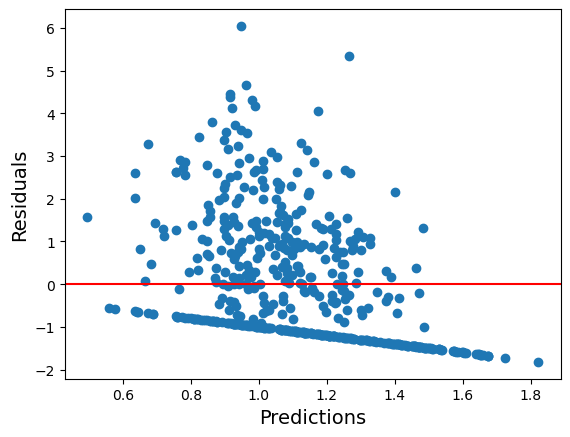

In [138]:
# Importing cross_val_predict to get predictions 
from sklearn.model_selection import cross_val_predict

# Predictions from our best model, bw2 CV 
y_pred = cross_val_predict(bw2, final[backward4.get_feature_names_out()], y, cv=5)

# Calculating residuals, observed - predictions
residuals = y - y_pred

# Residuals plot
plt.scatter(y_pred, residuals)

# Red H-line at y=0
plt.axhline(0, color='red')

# Axis labels
plt.xlabel('Predictions', size=14)
plt.ylabel('Residuals', size=14)

The line at `y=0` represents the sum of the residuals. The values above the line mean our model predicted too high and the values below the line mean our model predicted too low. Variance increase as our predictions increase. In other words, the data doesn't fit our model that well.

In [143]:
# Importing r2 score library
from sklearn.metrics import r2_score

# Retreiving the r2 score of our backward2 model
r2 = r2_score(y, y_pred)

print(f'r2 score: {round(r2, 2)}')

r2 score: -0.12


R2 score, or coefficient of determination, is a metric that measures how well the model predicts an outcome in variance. A R2 of 1 would represent a perfectly fitted model. Our R2 score of -0.12 shows again that our data doesn't fit our model well. 

# Conclusion

Using linear regression to predict forest fire damage didn’t yield satisfactory results. The right-skewed distribution of the "area" variable, with many extreme values near zero, disrupts the linearity between the predictors and the target variable.

We also observed several naturally occurring outliers in the data, as well as an anomaly in March, which showed an unusually high number of fires compared to other non-summer months. Given these challenges, we might explore alternative models, such as decision tree regression or random forest regression, which can better handle non-linear relationships and outliers.

Additionally, consulting with experts in forest fire behavior could provide valuable insights that might help refine our model and improve predictions.

After all, nature is often unpredictable!